In [9]:
%pip install pyspark
%pip install scikit-learn
%pip install matplotlib
%pip install pandas



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import warnings

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

import os

In [11]:
warnings.filterwarnings('ignore')

In [12]:
# Initialize Spark session
spark = SparkSession.builder.appName("CrimePatrol1").getOrCreate()

# Load dataset
crime_data = spark.read.csv("Resources/Major_Crime_Indicators_Open_Data.csv", header=True, inferSchema=True)

# Explore the dataset
crime_data.printSchema()


root
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- OBJECTID: integer (nullable = true)
 |-- EVENT_UNIQUE_ID: string (nullable = true)
 |-- REPORT_DATE: string (nullable = true)
 |-- OCC_DATE: string (nullable = true)
 |-- REPORT_YEAR: integer (nullable = true)
 |-- REPORT_MONTH: string (nullable = true)
 |-- REPORT_DAY: integer (nullable = true)
 |-- REPORT_DOY: integer (nullable = true)
 |-- REPORT_DOW: string (nullable = true)
 |-- REPORT_HOUR: integer (nullable = true)
 |-- OCC_YEAR: integer (nullable = true)
 |-- OCC_MONTH: string (nullable = true)
 |-- OCC_DAY: integer (nullable = true)
 |-- OCC_DOY: integer (nullable = true)
 |-- OCC_DOW: string (nullable = true)
 |-- OCC_HOUR: integer (nullable = true)
 |-- DIVISION: string (nullable = true)
 |-- LOCATION_TYPE: string (nullable = true)
 |-- PREMISES_TYPE: string (nullable = true)
 |-- UCR_CODE: integer (nullable = true)
 |-- UCR_EXT: integer (nullable = true)
 |-- OFFENCE: string (nullable = true)
 |-- M

In [13]:
# Drop if exists
crime_data = crime_data.drop(crime_data.X)
crime_data = crime_data.drop(crime_data.Y)
crime_data = crime_data.drop(crime_data.OBJECTID)
crime_data = crime_data.drop(crime_data.EVENT_UNIQUE_ID)
crime_data = crime_data.drop(crime_data.REPORT_DATE)
crime_data = crime_data.drop(crime_data.REPORT_YEAR)
crime_data = crime_data.drop(crime_data.REPORT_MONTH)
crime_data = crime_data.drop(crime_data.REPORT_DAY)
crime_data = crime_data.drop(crime_data.REPORT_DOY)
crime_data = crime_data.drop(crime_data.REPORT_DOW)
crime_data = crime_data.drop(crime_data.REPORT_HOUR)
crime_data = crime_data.drop(crime_data.OCC_YEAR)
crime_data = crime_data.drop(crime_data.OCC_MONTH)
crime_data = crime_data.drop(crime_data.OCC_DAY)
crime_data = crime_data.drop(crime_data.OCC_DATE)
crime_data = crime_data.drop(crime_data.OCC_DOY)
crime_data = crime_data.drop(crime_data.DIVISION)
crime_data = crime_data.drop(crime_data.LOCATION_TYPE)
crime_data = crime_data.drop(crime_data.PREMISES_TYPE)
crime_data = crime_data.drop(crime_data.UCR_CODE)
crime_data = crime_data.drop(crime_data.UCR_EXT)
crime_data = crime_data.drop(crime_data.OFFENCE)
crime_data = crime_data.drop(crime_data.HOOD_158)
crime_data = crime_data.drop(crime_data.NEIGHBOURHOOD_158)
crime_data = crime_data.drop(crime_data.HOOD_140)
crime_data = crime_data.drop(crime_data.NEIGHBOURHOOD_140)


# Rename columns
crime_data = crime_data.withColumnRenamed("LONG_WGS84", "longitude")
crime_data = crime_data.withColumnRenamed("LAT_WGS84", "latitude")
crime_data = crime_data.withColumnRenamed("OCC_DOW", "dayOfTheWeek")
crime_data = crime_data.withColumnRenamed("OCC_HOUR", "hourOfTheDay")
crime_data = crime_data.withColumnRenamed("MCI_CATEGORY", "offence")

# Remove trailing spaces from the 'dayOfTheWeek' column
crime_data = crime_data.withColumn("dayOfTheWeek", trim(crime_data["dayOfTheWeek"]))

# Define a UDF to map days to indices
day_mapping = {"Sunday": 1, "Monday": 2, "Tuesday": 3, "Wednesday": 4, "Thursday": 5, "Friday": 6, "Saturday": 7}
day_to_index_udf = udf(lambda day: day_mapping.get(day, -1), IntegerType())

# Apply the UDF to create a new column 'dayIndex'
crime_data = crime_data.withColumn("dayIndex", day_to_index_udf(col("dayOfTheWeek")))

crime_data.printSchema()
crime_data.show(15)


root
 |-- dayOfTheWeek: string (nullable = true)
 |-- hourOfTheDay: integer (nullable = true)
 |-- offence: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- dayIndex: integer (nullable = true)

+------------+------------+---------------+-----------------+----------------+--------+
|dayOfTheWeek|hourOfTheDay|        offence|        longitude|        latitude|dayIndex|
+------------+------------+---------------+-----------------+----------------+--------+
|   Wednesday|           0|        Assault|-79.3842059245105|43.6707982509655|       4|
|   Wednesday|           0|        Assault|-79.3457948187012|43.7036843035894|       4|
|   Wednesday|          10|        Assault|-79.3791313378142|43.6459808612379|       4|
|   Wednesday|           0|        Assault|-79.3832001629001|43.6543126531725|       4|
|   Wednesday|           8|        Assault|-79.5137965538313|43.7198240863369|       4|
|   Wednesday|           8|Break and Ent

In [14]:
#drop invalid entries

#drop entries with latitude or longitude of 0 which are invalid in our data
crime_data = crime_data.filter(crime_data["latitude"] != 0)
crime_data = crime_data.filter(crime_data["longitude"] != 0)

#drop entries that were inputted with an hour outside the 24 hr clock
crime_data = crime_data.filter((col("hourOfTheDay") >= 0) & (col("hourOfTheDay") <= 23))

#drop entries without a valid day of the week
valid_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
crime_data = crime_data.filter(trim(crime_data["dayOfTheWeek"]).isin(valid_days))


crime_data.show(15)

# Write csv file and overwrite if exists
crime_data.write.option("header", "true").mode("overwrite").csv("./Cleaned")





+------------+------------+---------------+-----------------+----------------+--------+
|dayOfTheWeek|hourOfTheDay|        offence|        longitude|        latitude|dayIndex|
+------------+------------+---------------+-----------------+----------------+--------+
|   Wednesday|           0|        Assault|-79.3842059245105|43.6707982509655|       4|
|   Wednesday|           0|        Assault|-79.3457948187012|43.7036843035894|       4|
|   Wednesday|          10|        Assault|-79.3791313378142|43.6459808612379|       4|
|   Wednesday|           0|        Assault|-79.3832001629001|43.6543126531725|       4|
|   Wednesday|           8|        Assault|-79.5137965538313|43.7198240863369|       4|
|   Wednesday|           8|Break and Enter| -79.421673390898|43.7923239909928|       4|
|   Wednesday|           9|        Assault|-79.3383011325343|43.6741310288285|       4|
|   Wednesday|           4|        Assault|-79.4839287578705|43.7343540636839|       4|
|   Wednesday|           4|     

k:  1  & WCSS:  4915.7922772360125
k:  2  & WCSS:  2284.2295897217473
k:  3  & WCSS:  1299.1820037179914
k:  4  & WCSS:  1034.6974067063113
k:  5  & WCSS:  836.8196979119621
k:  6  & WCSS:  662.819712705217
k:  7  & WCSS:  563.0474005453696
k:  8  & WCSS:  482.85747571883644
k:  9  & WCSS:  414.4719304232734
k:  10  & WCSS:  371.4180400106639
k:  11  & WCSS:  343.3711937764576
k:  12  & WCSS:  317.58606930245776
k:  13  & WCSS:  297.6705597098578
k:  14  & WCSS:  273.15604000412975
k:  15  & WCSS:  255.5364709780518
k:  16  & WCSS:  242.6153387601206
k:  17  & WCSS:  226.530733925915
k:  18  & WCSS:  213.5018871126555
k:  19  & WCSS:  202.65330348263606


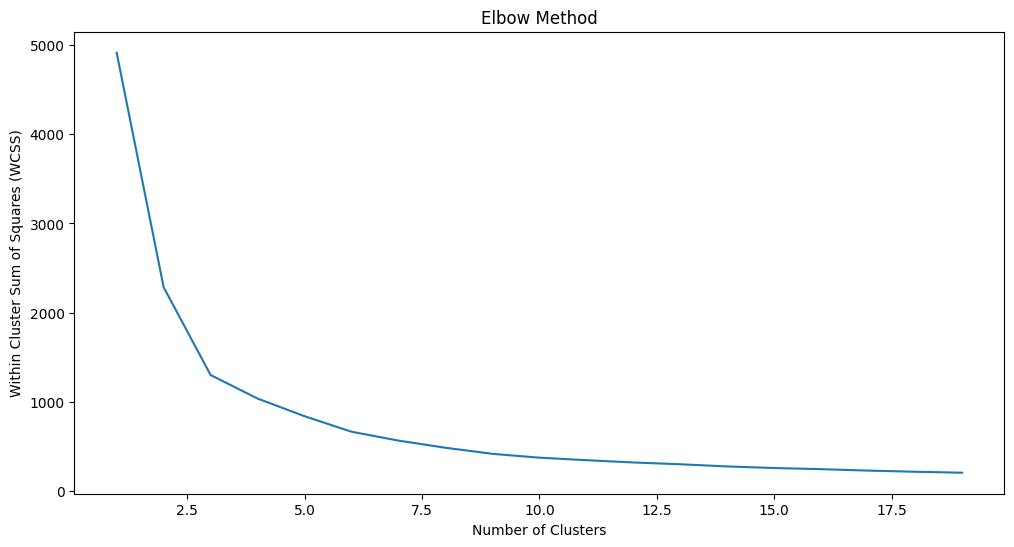

In [15]:
feature_cols = ["latitude", "longitude"]
pd_crime_data = crime_data[feature_cols].toPandas()

wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(pd_crime_data)
    wcss.append(kmeans.inertia_)
    
    print("k: ", str(i), ' & WCSS: ', kmeans.inertia_)

    

# Plotting WCSS graph.
plt.figure(figsize=(12, 6), dpi=100)

plt.plot(range(1, 20), wcss)

plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')

plt.show()


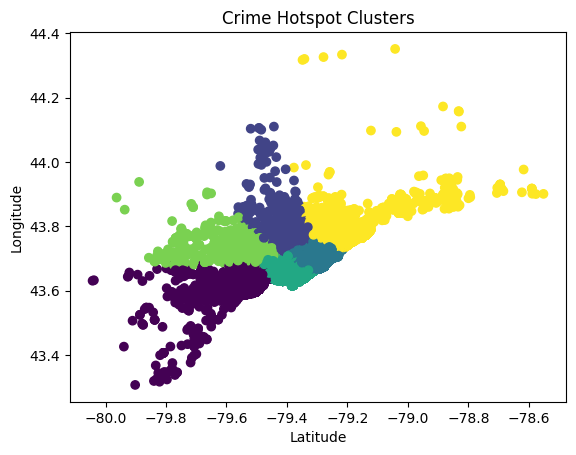

In [16]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pd_crime_data)

optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=0)
pd_crime_data["prediction"] = kmeans.fit_predict(X_scaled)

#adding back additional data
day_of_week_series = crime_data.select("dayOfTheWeek").toPandas()["dayOfTheWeek"]
hour_of_day_series = crime_data.select("hourOfTheDay").toPandas()["hourOfTheDay"]
offence_series = crime_data.select("offence").toPandas()["offence"]
pd_crime_data["dayOfTheWeek"] = day_of_week_series
pd_crime_data["hourOfTheDay"] = hour_of_day_series
pd_crime_data["offence"] = offence_series





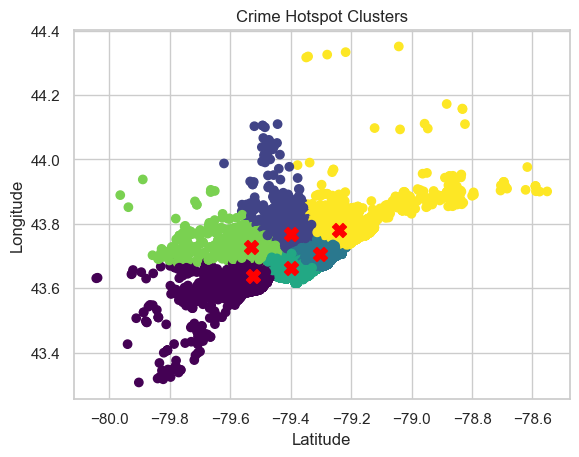

In [58]:
#Calculate centroids
centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)


# Visualize the clusters on a map
plt.scatter(pd_crime_data['longitude'], pd_crime_data['latitude'], c=pd_crime_data['prediction'], cmap='viridis')
plt.scatter(centroids[:, 1], centroids[:, 0], marker='X', s=100, color='red', label='Centroids')
plt.title('Crime Hotspot Clusters')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()


In [18]:
pip install seaborn matplotlib pandas



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


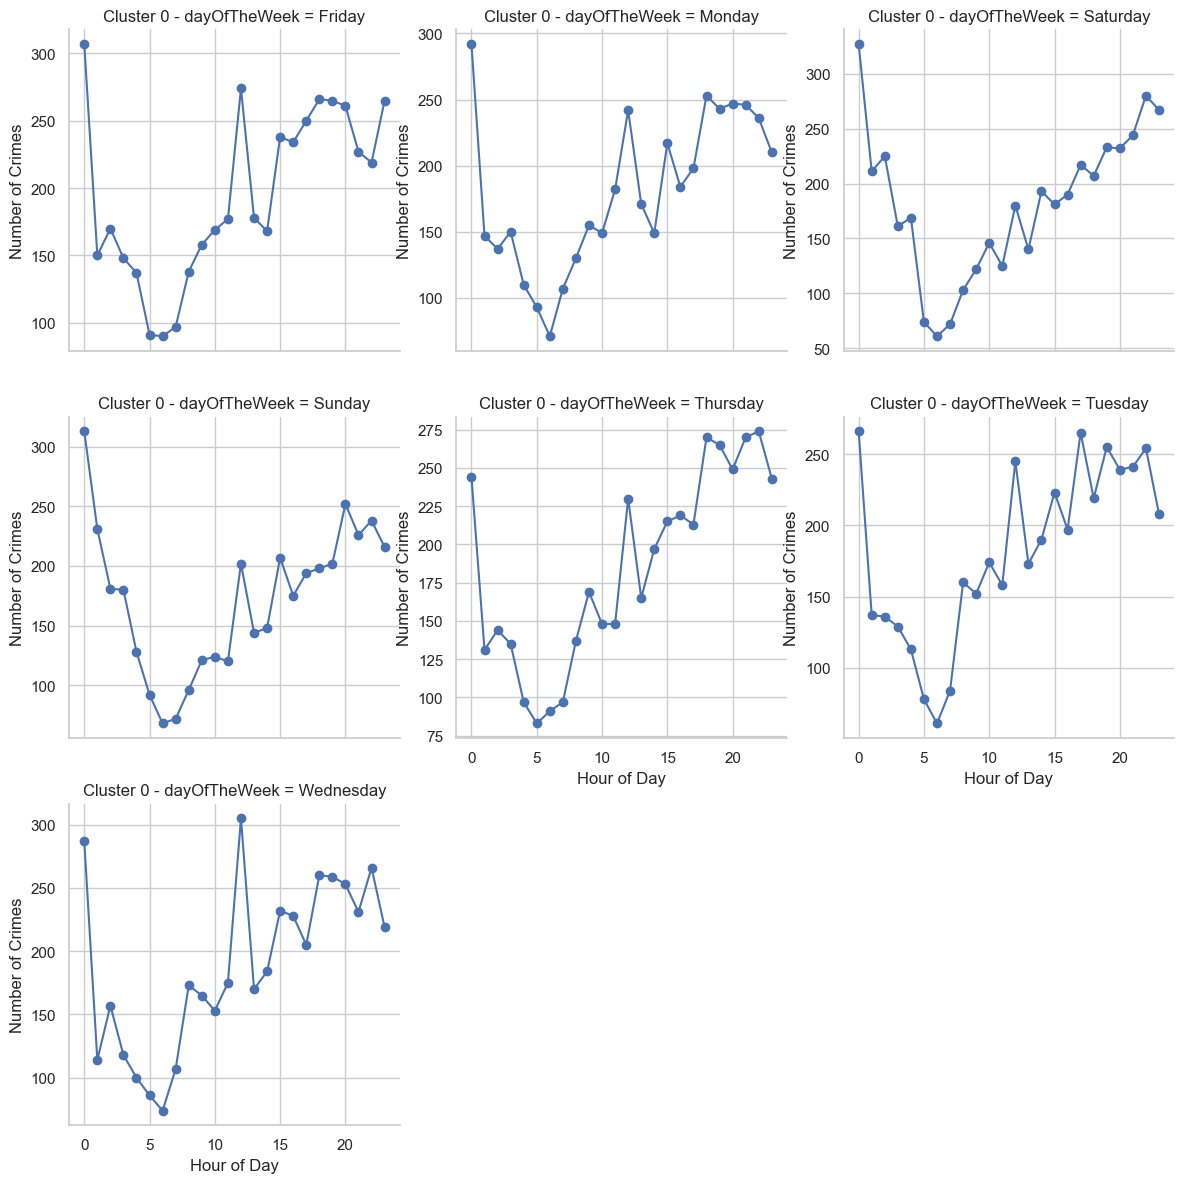

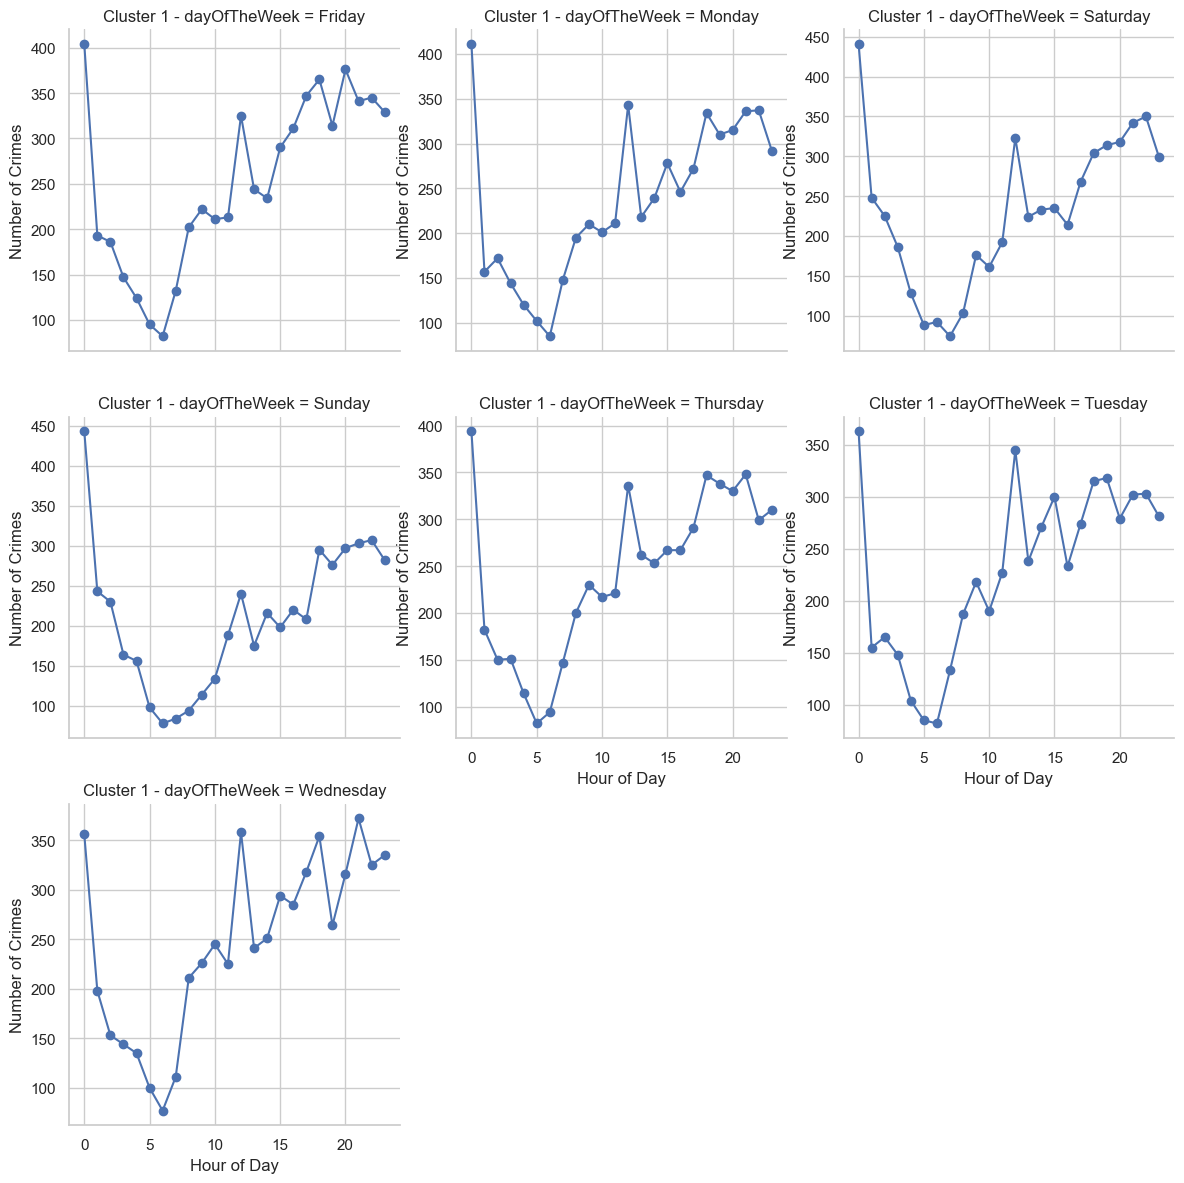

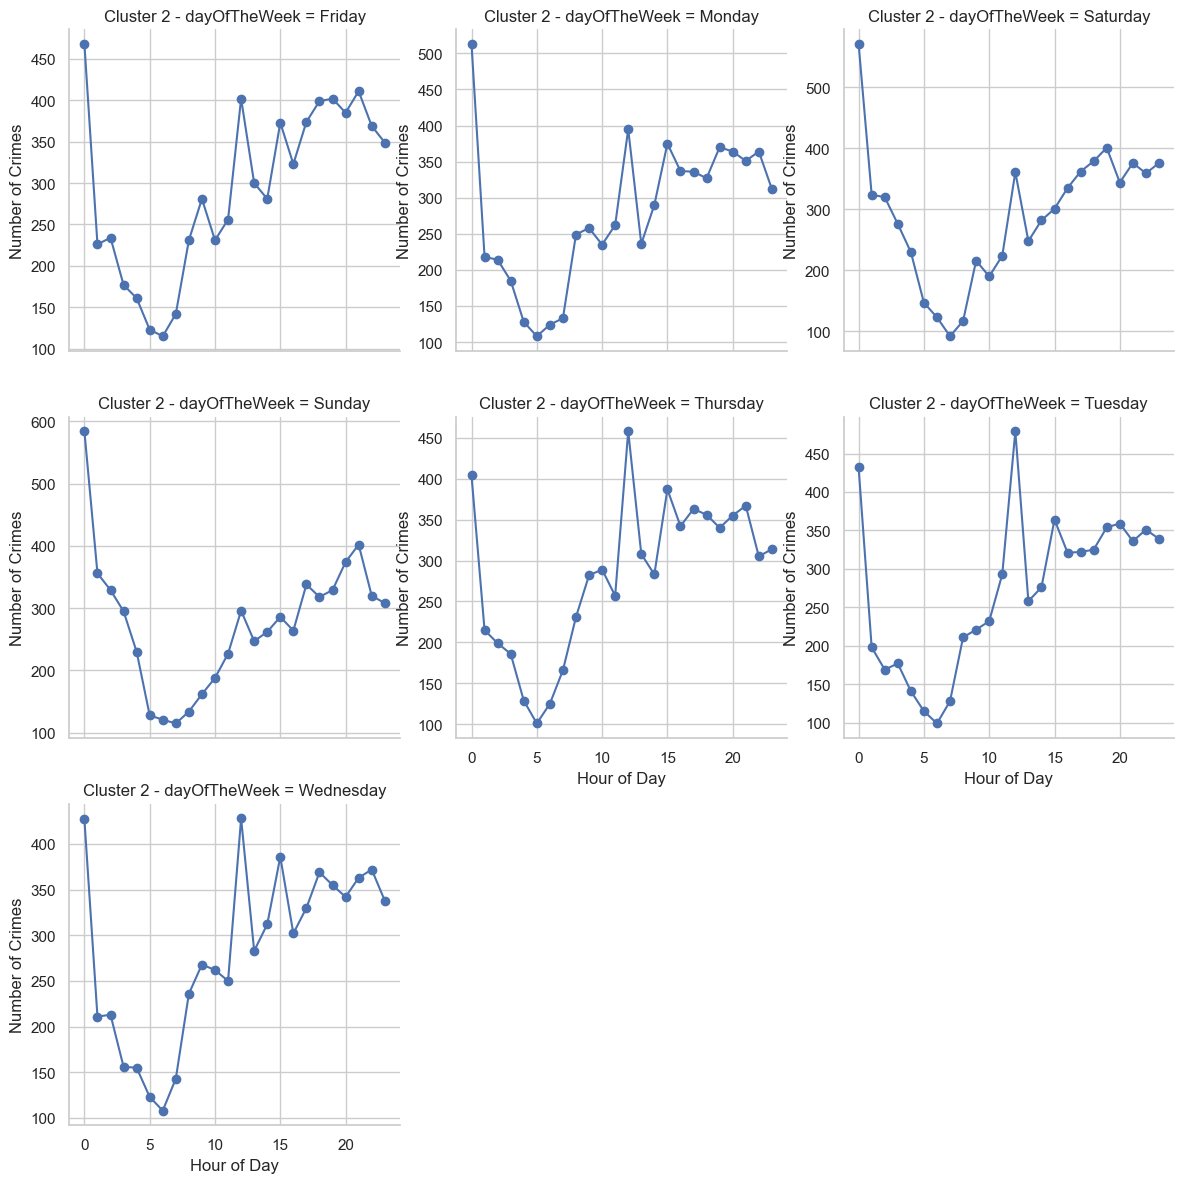

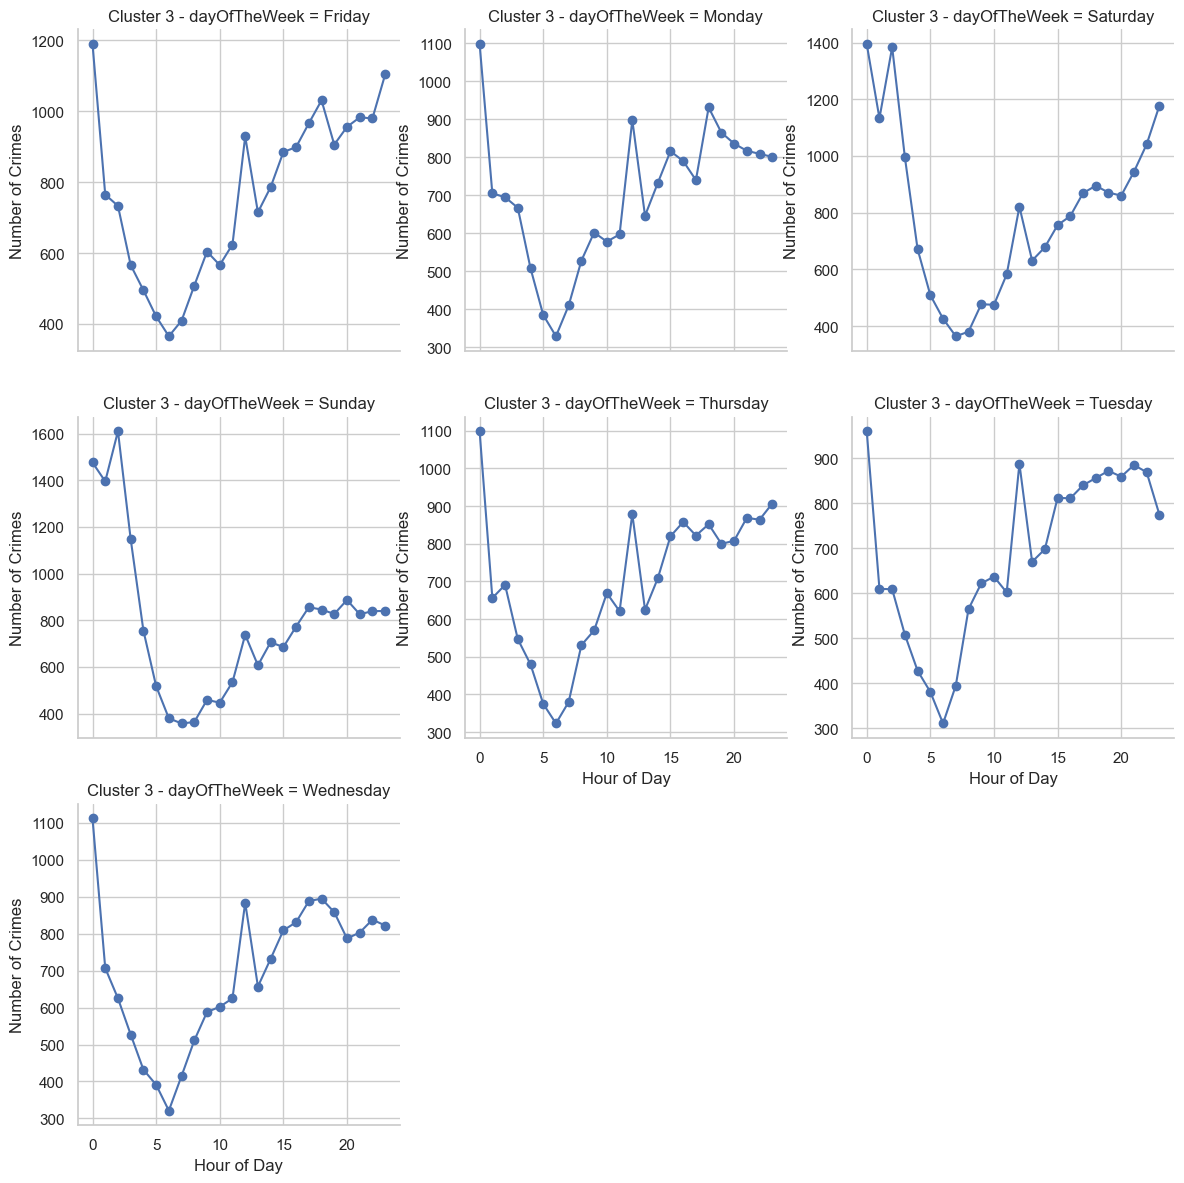

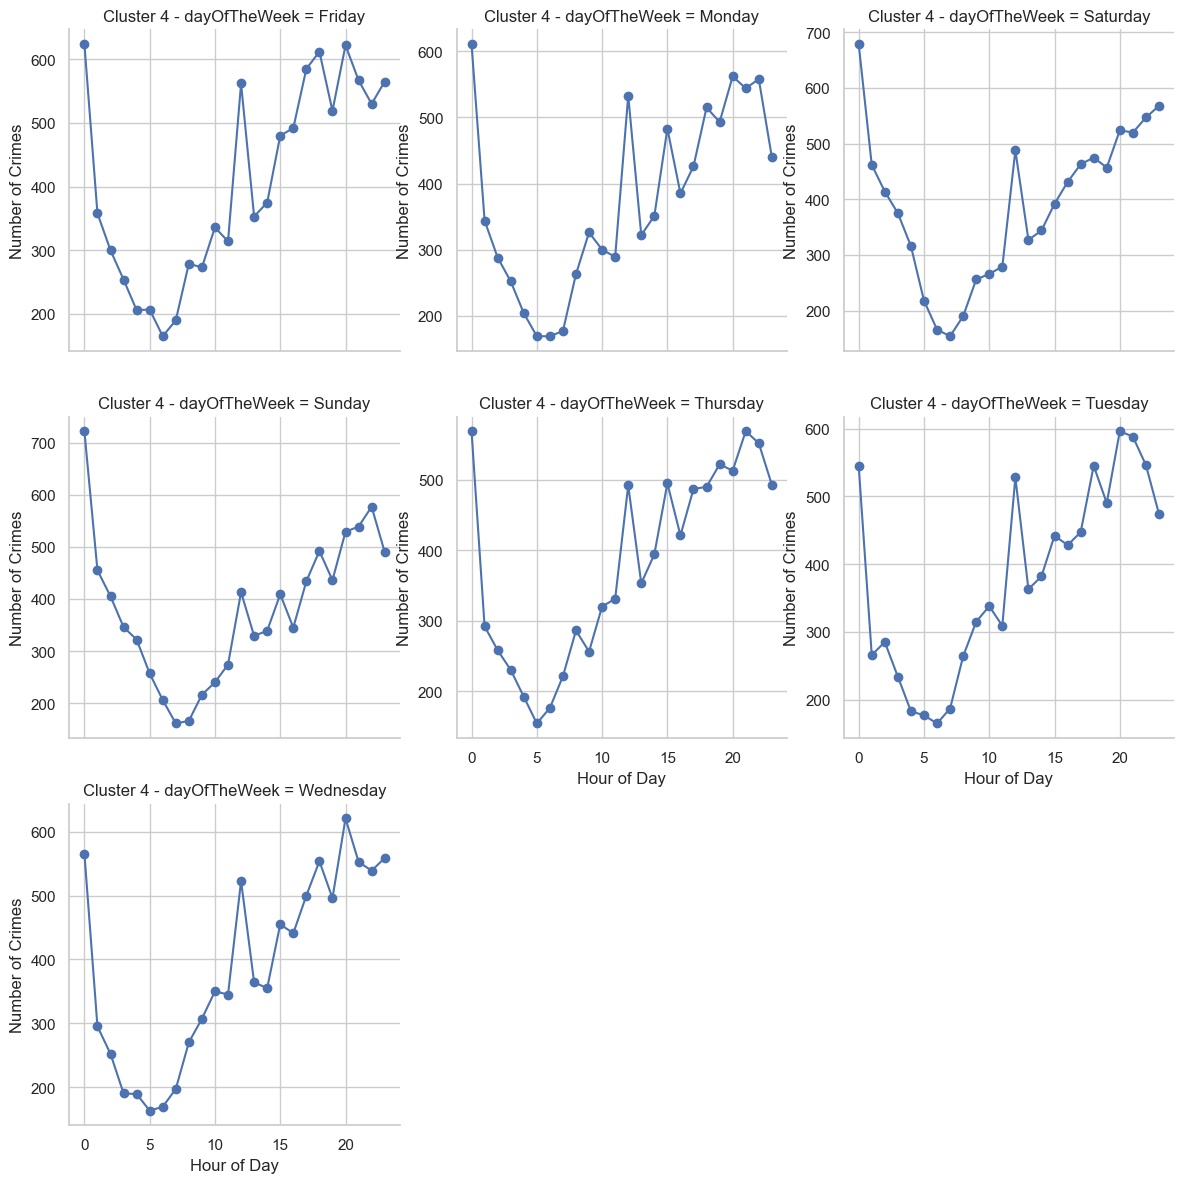

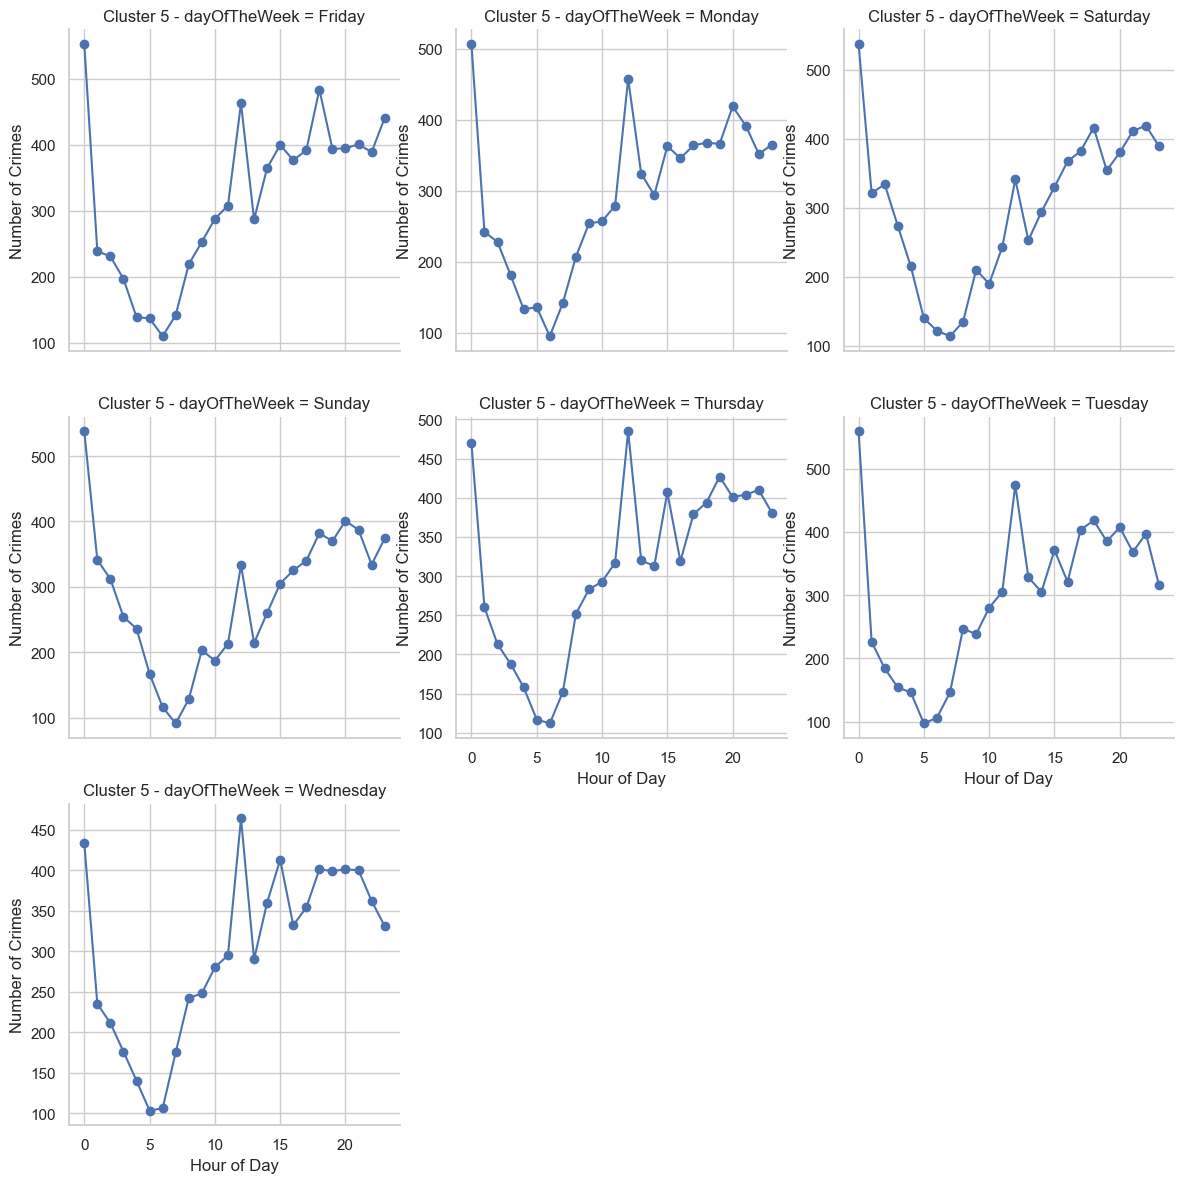

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame for day-wise and cluster-wise crime counts
day_cluster_counts = pd_crime_data.groupby(['dayOfTheWeek', 'prediction', 'hourOfTheDay']).size().reset_index(name='count')

# Set the style for the plots
sns.set(style="whitegrid")

# Iterate over clusters and create a separate plot for each
for cluster_label in day_cluster_counts['prediction'].unique():
    cluster_data = day_cluster_counts[day_cluster_counts['prediction'] == cluster_label]

    # Create a facet grid for each day of the week
    g = sns.FacetGrid(cluster_data, col="dayOfTheWeek", col_wrap=3, height=4, sharey=False)
    
    # Plot the crime counts for each hour
    g.map(plt.plot, 'hourOfTheDay', 'count', marker="o", color="b")

    # Set titles and labels
    for ax in g.axes.flat:
        ax.set_title(f"Cluster {cluster_label} - {ax.get_title()}")
        ax.set_xlabel("Hour of Day")
        ax.set_ylabel("Number of Crimes")

    # Show the plots
    plt.show()


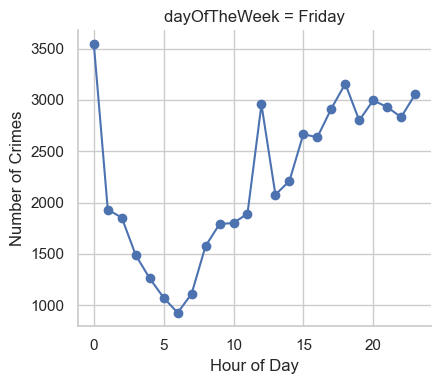

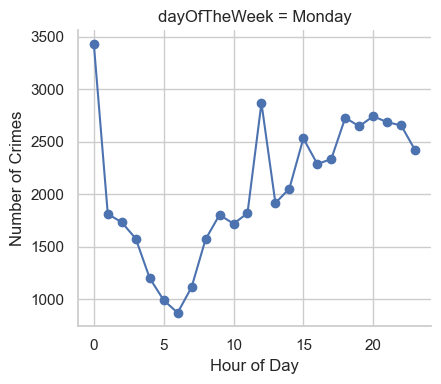

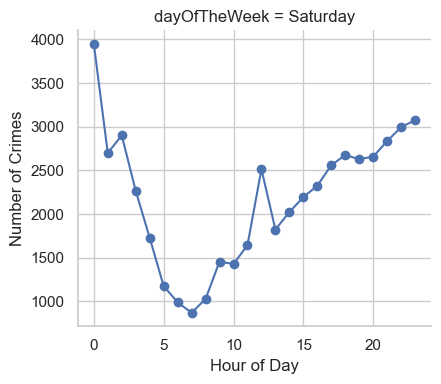

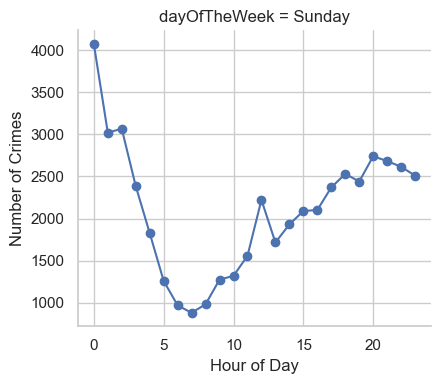

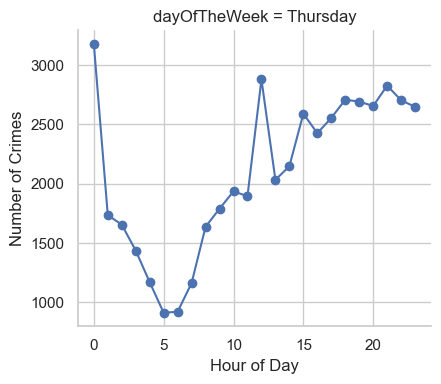

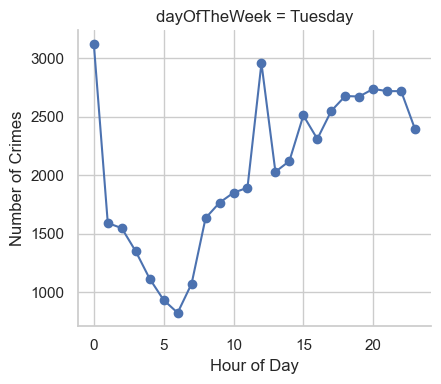

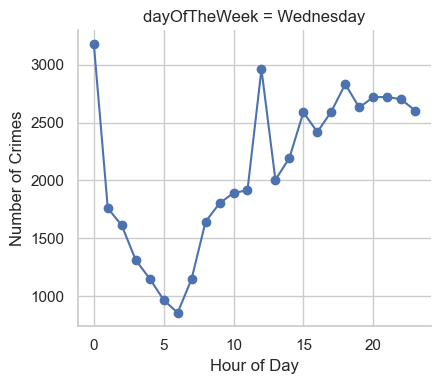

In [48]:
# Create a new DataFrame for day-wise and overall crime counts
overall_day_counts = pd_crime_data.groupby(['dayOfTheWeek', 'hourOfTheDay']).size().reset_index(name='count')

# Set the style for the plots
sns.set(style="whitegrid")

# Define a mapping for numerical day indices to day names
day_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

# Iterate over days and create a separate plot for each
for day_index in overall_day_counts['dayOfTheWeek'].unique():
    overall_day_data = overall_day_counts[overall_day_counts['dayOfTheWeek'] == day_index]

    # Create a facet grid for each day of the week
    g = sns.FacetGrid(overall_day_data, col="dayOfTheWeek", col_wrap=3, height=4, sharey=False)
    
    # Plot the crime counts for each hour
    g.map(plt.plot, 'hourOfTheDay', 'count', marker="o", color="b")

    # Set titles and labels
    for ax in g.axes.flat:
        ax.set_title(f"{ax.get_title()}")
        ax.set_xlabel("Hour of Day")
        ax.set_ylabel("Number of Crimes")

    # Show the plots
    plt.show()


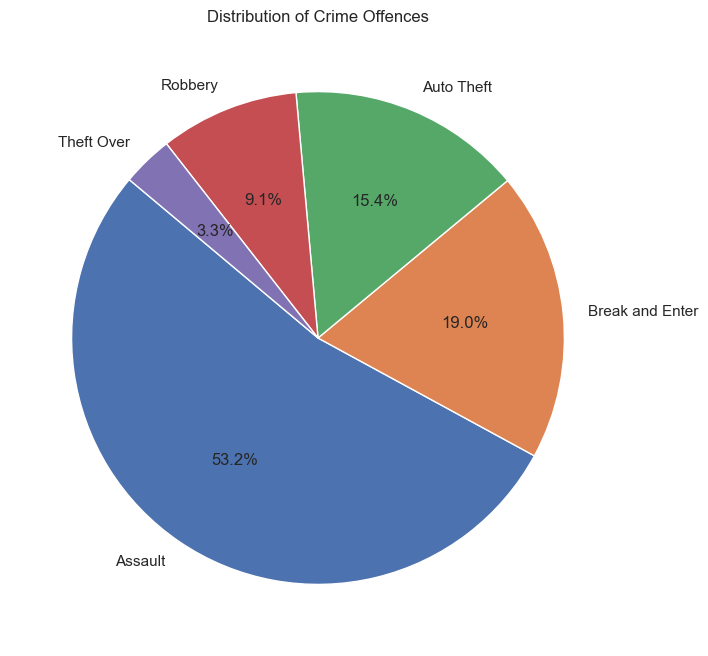

In [49]:
import matplotlib.pyplot as plt

# Group by the category column and count occurrences
category_counts = pd_crime_data['offence'].value_counts()

# Plot a pie chart for all data
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Crime Offences')
plt.show()



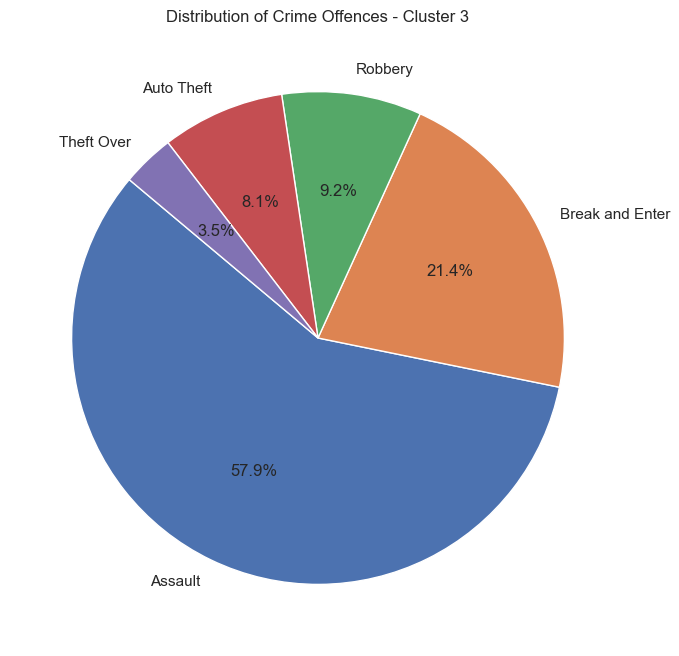

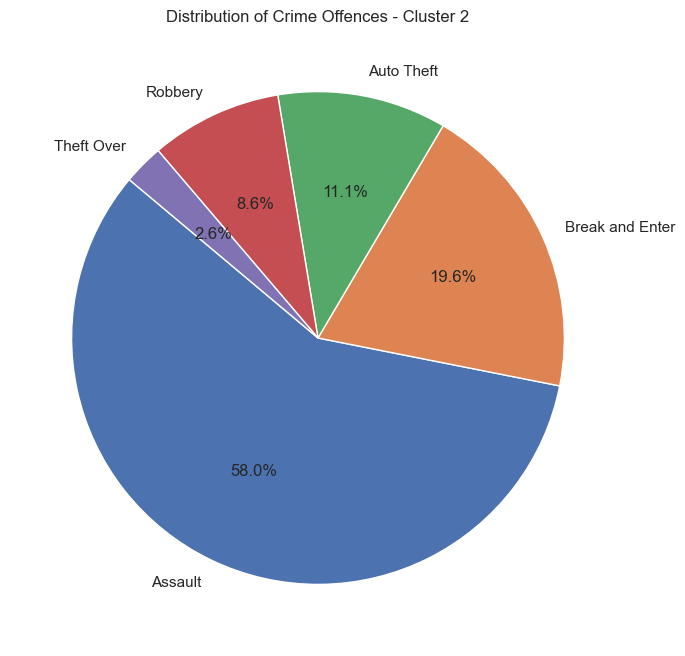

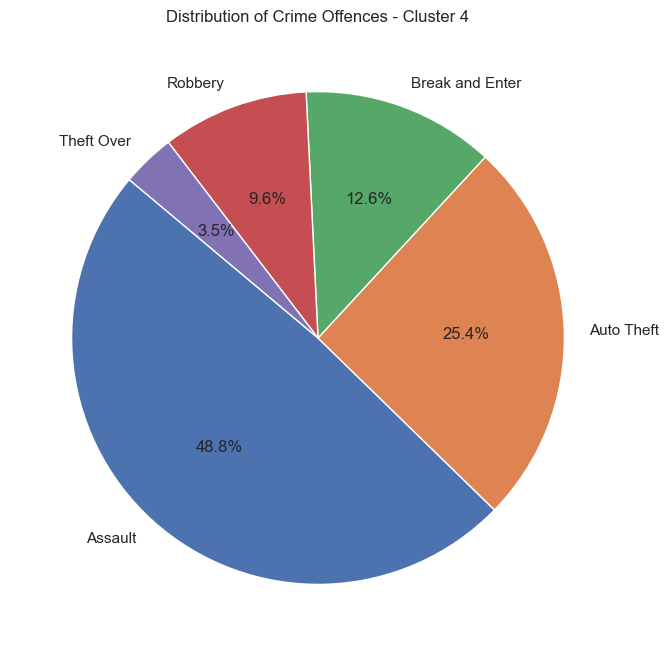

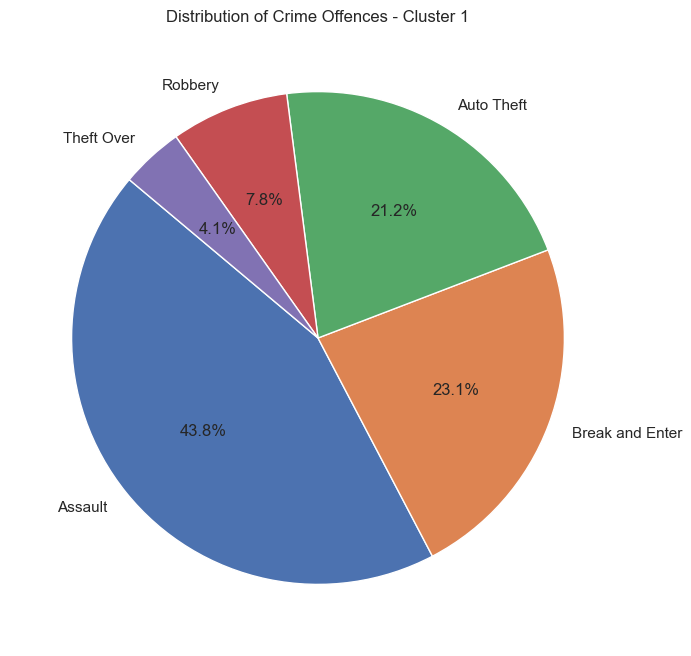

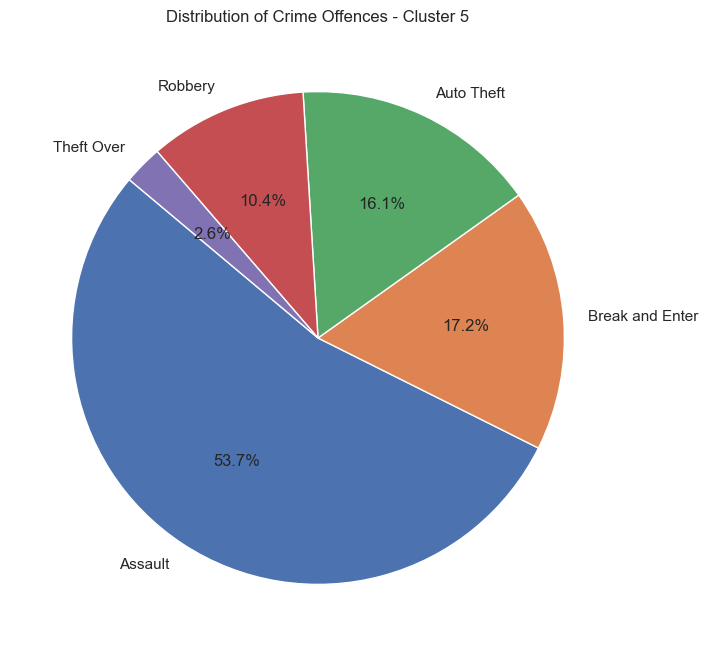

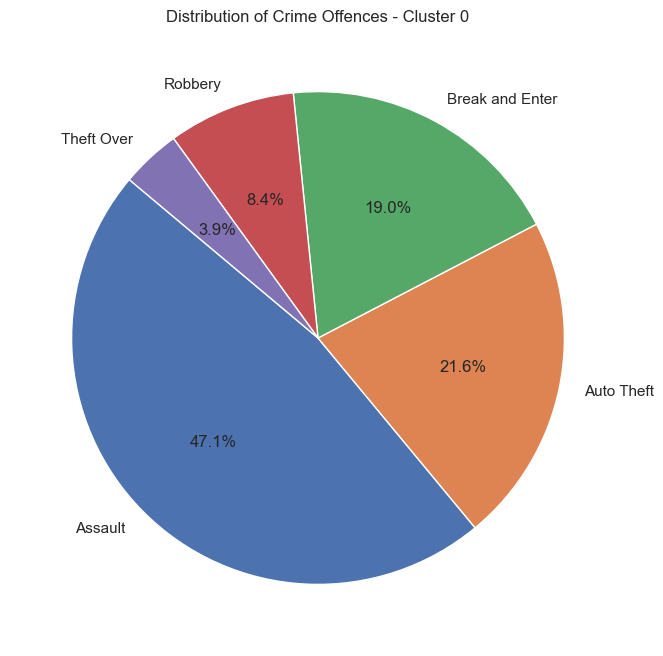

In [50]:
# Iterate over clusters and create a pie chart for each
for cluster_label in pd_crime_data['prediction'].unique():
    cluster_data = pd_crime_data[pd_crime_data['prediction'] == cluster_label]

    # Group by the category column and count occurrences in the cluster
    category_counts = cluster_data['offence'].value_counts()

    # Plot a pie chart for the cluster
    plt.figure(figsize=(8, 8))
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of Crime Offences - Cluster {cluster_label}')
    plt.show()


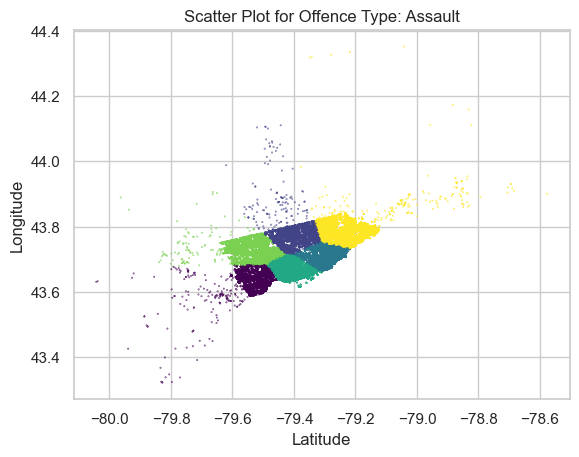

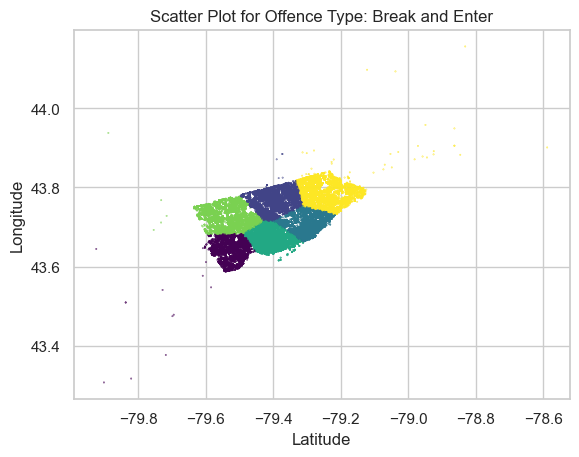

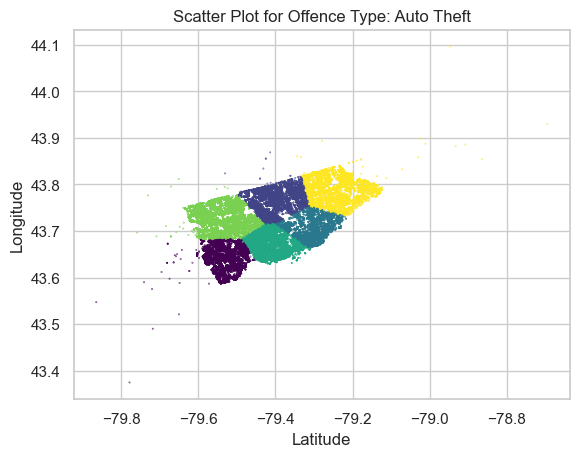

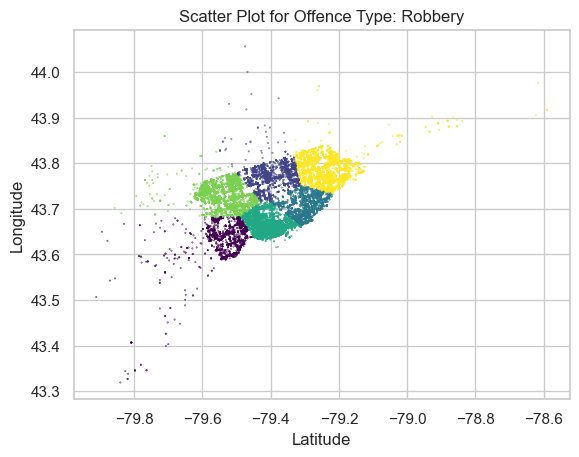

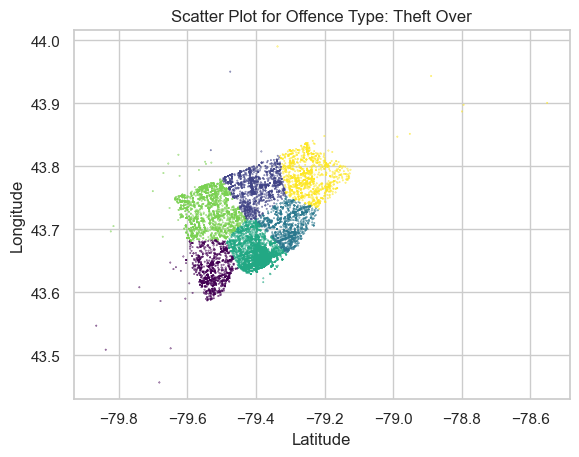

In [52]:
# Create a scatter plot for each offence type
sns.set(style="whitegrid")

# Get unique offence types
offence_types = pd_crime_data['offence'].unique()

# Iterate over offence types and create scatter plots
for offence_type in offence_types:
    # Filter data for the specific offence type
    offence_data = pd_crime_data[pd_crime_data['offence'] == offence_type]
    #Create plot
    plt.scatter(offence_data['longitude'], offence_data['latitude'], s=0.1, c=offence_data['prediction'], cmap='viridis')
    plt.title(f'Scatter Plot for Offence Type: {offence_type}')
    plt.ylabel('Longitude')
    plt.xlabel('Latitude')
    plt.show()


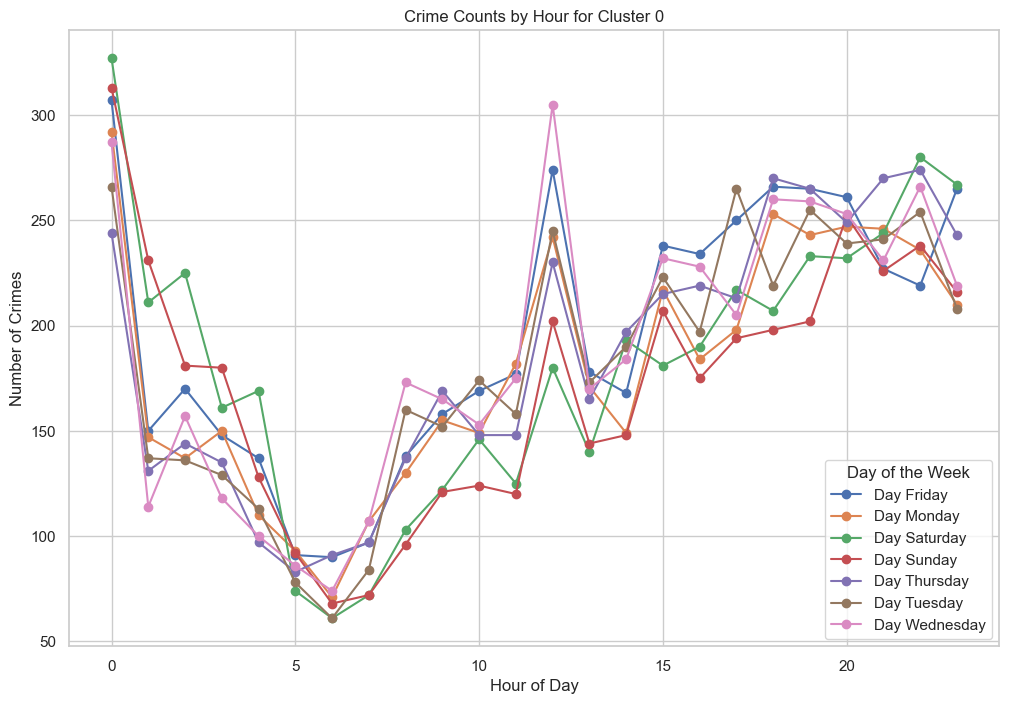

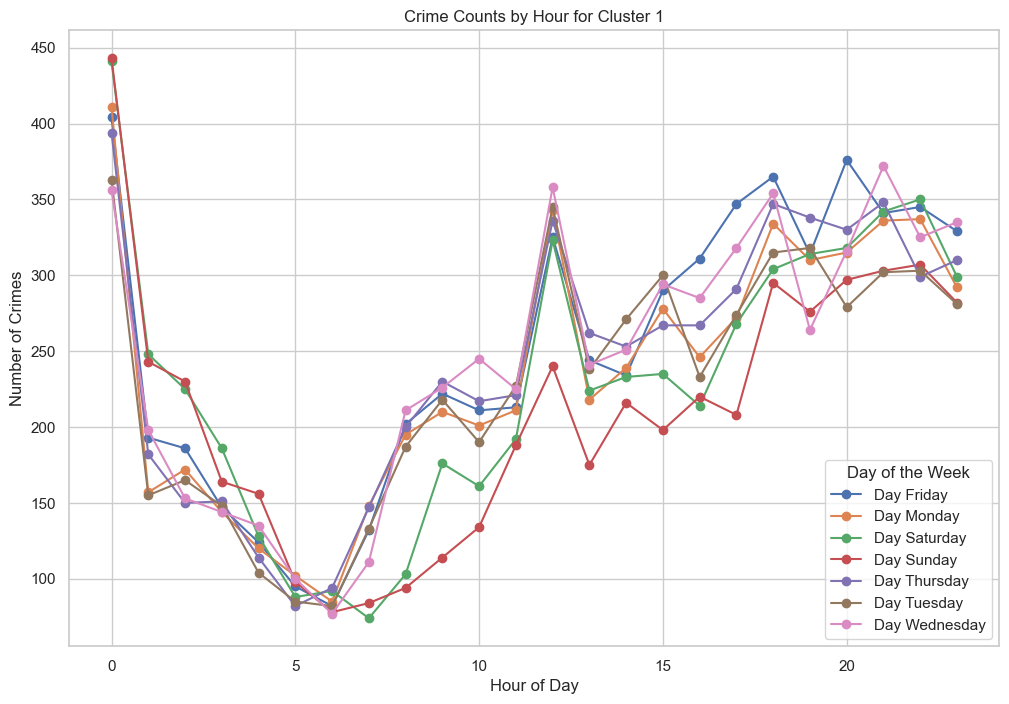

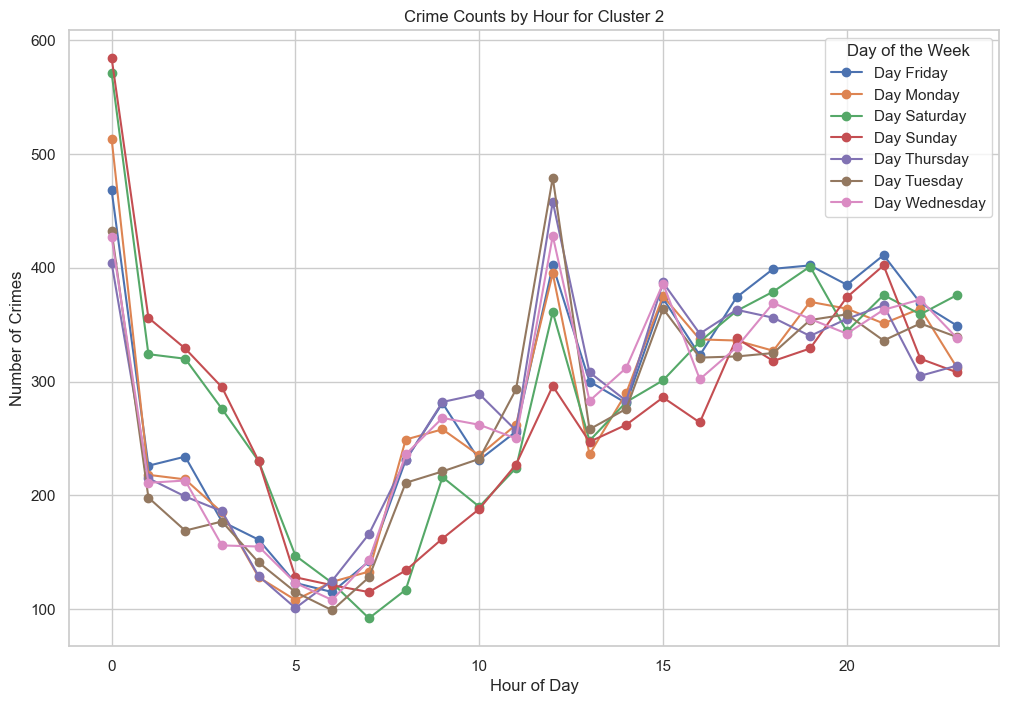

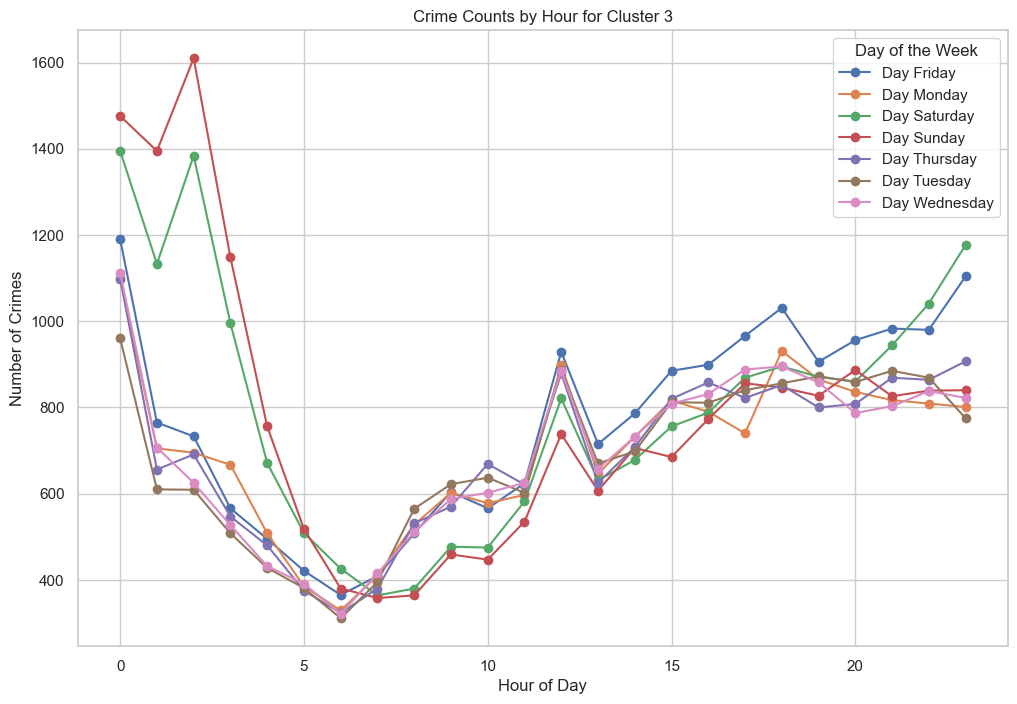

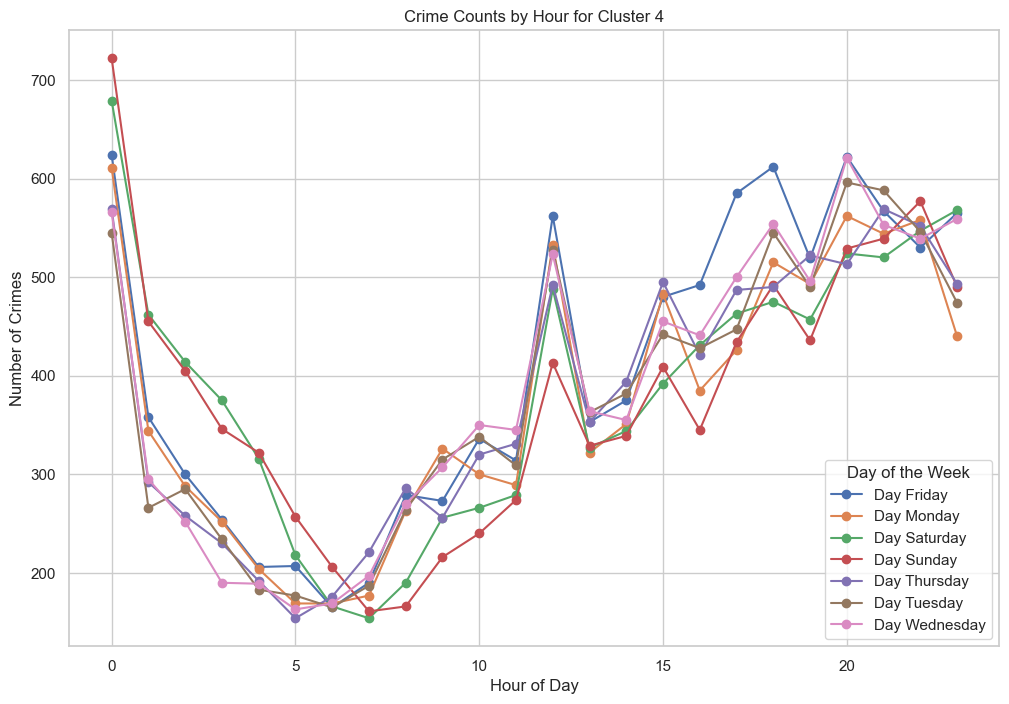

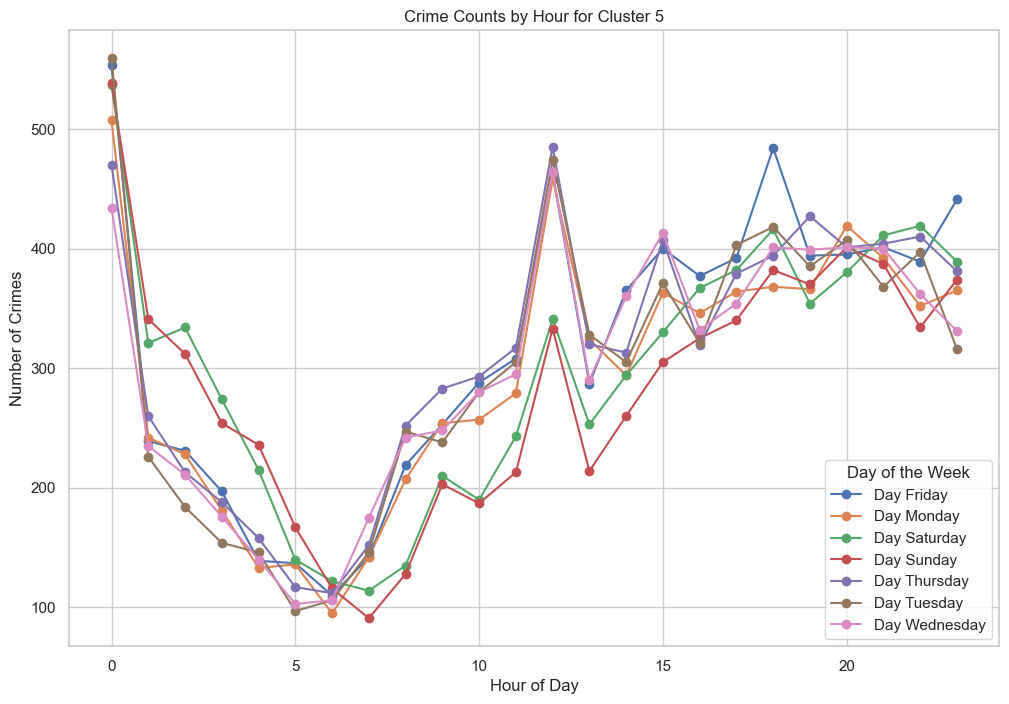

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame for day-wise and cluster-wise crime counts
day_cluster_counts = pd_crime_data.groupby(['dayOfTheWeek', 'prediction', 'hourOfTheDay']).size().reset_index(name='count')

# Set the style for the plots
sns.set(style="whitegrid")

# Get unique clusters
clusters = day_cluster_counts['prediction'].unique()

# Iterate over clusters and create a separate graph for each
for cluster_label in clusters:
    plt.figure(figsize=(12, 8))
    cluster_data = day_cluster_counts[day_cluster_counts['prediction'] == cluster_label]

    # Get unique days of the week
    days_of_week = cluster_data['dayOfTheWeek'].unique()

    # Plot each day with a different color on the same graph
    for day in days_of_week:
        day_data = cluster_data[cluster_data['dayOfTheWeek'] == day]
    
        # Plot the crime counts for each hour
        plt.plot(day_data['hourOfTheDay'], day_data['count'], marker="o", label=f'Day {day}')

    # Set titles and labels
    plt.title(f'Crime Counts by Hour for Cluster {cluster_label}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Crimes')
    plt.legend(title='Day of the Week')

    # Show the plots
    plt.show()
